In [2]:
import os
import cv2
from time import time
import numpy as np
import habitat
from env import Env
import quaternion
from IPython.display import clear_output
import matplotlib.pyplot as plt
from arguments import init_config
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
import pose as pu
%matplotlib inline

In [3]:
import argparse
import cv2
import matplotlib.pyplot as plt
from utils import draw_top_down_map
import numpy as np
import os

from vo_modules import VisualOdometry as VO
from libs.general.utils import *
from libs.utils import *

In [4]:
from gym.spaces.box import Box
from resnet_policy import PointNavResNetPolicy
from habitat_baselines.common.rollout_storage import RolloutStorage
import transformations as tf
from habitat_baselines.common.utils import batch_obs, linear_decay
from scipy.spatial.transform import Rotation as Rn
import torch
from habitat.core.logging import logger
from collections import defaultdict
from habitat.config.default import get_config
from habitat.core.agent import Agent
from typing import Any, Dict, Iterator, List, Optional, Tuple, Type, Union
import gym
from gym.spaces.dict_space import Dict as SpaceDict
from habitat.config import Config
from habitat.core.dataset import Dataset, Episode
from habitat.core.embodied_task import EmbodiedTask, Metrics
from habitat_baselines.config.default import get_config as cfg_baseline
from habitat_baselines.slambased.mappers import DirectDepthMapper
#import orbslam2
from habitat_baselines.slambased.reprojection import (
    homogenize_p,
    project_tps_into_worldmap)
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import minmax_scale
import numpy as np

In [5]:
def get_sim_location(pos,q):
    xx = -pos[2]
    zz = -pos[0]
    axis = quaternion.as_euler_angles(quaternion.from_float_array([q.w, q.x, q.y, q.z]))[0]
    if (axis%(2*np.pi)) < 0.1 or (axis%(2*np.pi)) > 2*np.pi - 0.1:
        o = quaternion.as_euler_angles(quaternion.from_float_array([q.w, q.x, q.y, q.z]))[1]
    else:
        o = 2*np.pi - quaternion.as_euler_angles(quaternion.from_float_array([q.w, q.x, q.y, q.z]))[1]
    if o > np.pi:
        o -= 2 * np.pi
        
    return xx, zz, o

In [6]:
res = transforms.Compose([transforms.ToPILImage(),
                    transforms.Resize((256, 256),
                                      interpolation = Image.NEAREST)])
res2 = transforms.Compose([transforms.ToPILImage(),
                    transforms.Resize((480, 640),
                                      interpolation = Image.NEAREST)])  

def inverse_transform(x, y, start_x, start_y, start_angle):
    new_x = (x - start_x) * np.cos(start_angle) + (y - start_y) * np.sin(start_angle)
    new_y = -(x - start_x) * np.sin(start_angle) + (y - start_y) * np.cos(start_angle)
    return new_x, new_y


    
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__    

In [7]:
rate = 20
D = [0, 0, 0, 0, 0]
K = [457, 0.0, 320.5, 0.0, 457, 180.5, 0.0, 0.0, 1.0]
R = [1, 0, 0, 0, 1, 0, 0, 0, 1]
P = [457, 0.0, 320.5, 0.0, 0.0, 457, 180.5, 0.0, 0.0, 0.0, 1.0, 0.0]
MAX_DEPTH = 10
W = 256#640
H = 256#360

In [8]:
obs_space = dotdict()
obs_space.spaces = {}
obs_space.spaces['depth'] = Box(low=-1000, high=1000, shape=(256,256,1), dtype=np.float32)
obs_space.spaces['rgb'] = Box(low=-1000, high=1000, shape=(256,256,3), dtype=np.float32)
obs_space.spaces['pos'] = Box(low=-1000, high=1000, shape=(2,), dtype=np.float32)

act_space = dotdict()
act_space.n = 4
act_space.shape = [1]

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

actor_critic = PointNavResNetPolicy(
    observation_space=obs_space,
    action_space=act_space,
    hidden_size=512,
    rnn_type='LSTM',
    num_recurrent_layers=2,
    backbone='resnet50',
    goal_sensor_uuid='pos',
    normalize_visual_inputs=False,
)
actor_critic.to(device)

pretrained_state = torch.load('ckpt.119.pth', map_location="cpu")
actor_critic.load_state_dict({k[len("actor_critic.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic" in k})

<All keys matched successfully>

In [9]:
config = init_config()
config.defrost()
config.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = True
config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0.1  # 0.1
config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0.2  # 0.5
config.SIMULATOR.TURN_ANGLE = 10  # 10
config.SIMULATOR.TILT_ANGLE = 10  # 10
config.SIMULATOR.FORWARD_STEP_SIZE = 0.25  # 0.25
config.SIMULATOR.RGB_SENSOR.HEIGHT = 360
config.SIMULATOR.RGB_SENSOR.WIDTH = 640
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = 360
config.SIMULATOR.DEPTH_SENSOR.WIDTH = 640
config.freeze()
config['DATASET']['SPLIT'] = 'train'
env = Env(config=config)

2020-06-20 15:45:40,691 Initializing dataset PointNav-v1
Initializing dataset PointNav-v1
2020-06-20 15:47:45,312 initializing sim Sim-v0
initializing sim Sim-v0
2020-06-20 15:47:51,522 Initializing task Nav-v0
Initializing task Nav-v0


In [10]:
rollouts = RolloutStorage(
    500,
    1,
    obs_space,
    act_space,
    512,
    num_recurrent_layers=actor_critic.net.num_recurrent_layers)
rollouts.to(device)

In [11]:
default_config_file = "options/kitti/kitti_default_configuration.yml"
config_files = [default_config_file, './options/custom_configuration.yml']
cfg = merge_cfg(config_files)
cfg.seq = str(cfg.seq)

In [12]:
# Random seed
SEED = cfg.seed
np.random.seed(SEED)

vo = VO(cfg)
vo.setup()

done = False
img_id = 0
n_reset = 7
observations, info, done = env.reset(n_reset)

obs_rgb = np.copy(res2(observations['rgb']))
obs_depth = np.copy(res2(observations['depth']))

observations['rgb'] = np.copy(res(observations['rgb']))
observations['depth'] = np.copy(res(observations['depth']))[:,:,np.newaxis]

start_time = time()

xx,yy = observations['pointgoal']
trux = 0; truy = 0
goalx, goaly = xx,-yy
xdif,ydif = trux-goalx, truy-goaly
observations['pos'] = [xdif,ydif]
batch = batch_obs([observations])
for sensor in rollouts.observations:
    rollouts.observations[sensor][0].copy_(batch[sensor])

pos = env.sim.get_agent_state().position
q = env.sim.get_agent_state().rotation
dfvo_last_sim_location = [0.,0.,0.]#get_sim_location(pos,q)
last_sim_location = [0.,0.,0.]
curr_loc = [0.,0.,0.]
dfvo_curr_loc = [0.,0.,0.]

==> initialize LiteFlowNet with [model/network-default.pytorch]


/opt/conda/envs/habitat/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [13]:
vo.gt_poses = {0.0: np.array([[ 0.22485091,  0.        ,  0.97439318,  0.        ],
                       [ 0.        ,  1.        ,  0.        ,  0.        ],
                       [-0.97439318,  0.        ,  0.22485091,  0.        ],
                       [ 0.        ,  0.        ,  0.        ,  1.        ]])}
vo.rgb_d_pose_pair = vo.synchronize_rgbd_pose_pairs()
len_seq = len(vo.rgb_d_pose_pair)
main_start_time = time()
start_frame = 0

In [14]:
vo.tracking_mode = "Ess. Mat."
start_time = time()
print(observations['rgb'].shape,obs_rgb.shape)
vo.cur_data['id'] = img_id
vo.cur_data['timestamp'] = sorted(list(vo.rgb_d_pose_pair.keys()))[img_id]
vo.cur_data['img'] = obs_rgb
vo.timers.timers["img_reading"].append(time()-start_time)
vo.cur_data['raw_depth'] = obs_depth
vo.cur_data['depth'] = preprocess_depth(vo.cur_data['raw_depth'], vo.cfg.crop.depth_crop, [vo.cfg.depth.min_depth, vo.cfg.depth.max_depth])
start_time = time()
vo.tracking_hybrid()
vo.timers.timers["tracking"].append(time()-start_time)
start_time = time()
#vo=vo.drawer.main(vo)
vo.timers.timers["visualization"].append(time()-start_time)

vo.ref_data, vo.cur_data = vo.update_ref_data(
                                    vo.ref_data,
                                    vo.cur_data,
                                    vo.window_size,
                                    vo.keyframe_step)

(256, 256, 3) (480, 640, 3)


In [ ]:
!rm -r ./images/
!mkdir ./images/
dfvo_deg = []
dfvo_dif = []
dfvo_pos, dfvo_rot = [0, 0], 0
dfvo_cords = [np.copy(dfvo_pos)]
gt_deg = []
gt_dif = []
gt_pos, gt_rot = [0, 0], 0
gt_cords = [np.copy(gt_pos)]
gt_gt_cords = []
gt = []
go = []
pr_1 = []
pr_11 = []
pr_2 = []
pr_22 = []
pr_3 = []
pr_33 = []
p = 2 * np.pi
first = True
while not done:
    
    step_observation = {k: v[rollouts.step] for k, v in rollouts.observations.items()}
    (values, actions, actions_log_probs, recurrent_hidden_states) = actor_critic.act(
                step_observation,
                rollouts.recurrent_hidden_states[rollouts.step],
                rollouts.prev_actions[rollouts.step],
                rollouts.masks[rollouts.step])
            
    action = actions.item()
    
    if abs(xdif)<0.35 and abs(ydif)<0.35:
        action = 0
    
    observations, info, done = env.step(action, ideal_action=False)
    
    if done:
        continue
    
    obs_rgb = np.copy(res2(observations['rgb']))
    obs_depth = np.copy(res2(observations['depth']))


    observations['rgb'] = np.copy(res(observations['rgb']))
    observations['depth'] = np.copy(res(observations['depth']))[:,:,np.newaxis]
        
    pr_11.append([env.trux,env.truy])
    pr_1.append([env.dx_gt,env.dy_gt,env.do_gt])
    
    pos = env.sim.get_agent_state().position
    q = env.sim.get_agent_state().rotation
      
    curr_sim_pose = get_sim_location(pos,q)
    dx, dy, do = pu.get_rel_pose_change(curr_sim_pose, last_sim_location)
    last_sim_location = curr_sim_pose
    
    curr_loc = pu.get_new_pose(curr_loc,(dx, dy, do))
    
    pr_2.append([dx, dy, do])    
    pr_22.append(curr_loc)
    
    vo.tracking_mode = "Ess. Mat."
    start_time = time()
    vo.cur_data['id'] = img_id
    vo.cur_data['timestamp'] = sorted(list(vo.rgb_d_pose_pair.keys()))[-1]
    vo.cur_data['img'] = obs_rgb
    vo.timers.timers["img_reading"].append(time()-start_time)
    vo.cur_data['raw_depth'] = obs_depth
    vo.cur_data['depth'] = preprocess_depth(vo.cur_data['raw_depth'], vo.cfg.crop.depth_crop, [vo.cfg.depth.min_depth, vo.cfg.depth.max_depth])
    start_time = time()
    vo.tracking_hybrid()
    vo.timers.timers["tracking"].append(time()-start_time)
    start_time = time()
    #vo=vo.drawer.main(vo)
    vo.timers.timers["visualization"].append(time()-start_time)

    vo.ref_data, vo.cur_data = vo.update_ref_data(
                                        vo.ref_data,
                                        vo.cur_data,
                                        vo.window_size,
                                        vo.keyframe_step)
    
    timestamps = sorted(list(vo.rgb_d_pose_pair.keys()))
    global_poses_arr = convert_SE3_to_arr(vo.global_poses)#, timestamps)
    pose = global_poses_arr[len(global_poses_arr)-1]
    qx, qy, qz, qw = rot2quat(pose[:3, :3])
    tx, ty, tz = pose[:3, 3]*10.8
    
    if first:
        dfvo_last_sim_location = get_sim_location(np.array([tx,ty,tz]),quaternion.from_float_array([qw, qx, qy, qz]))
    dfvo_curr_sim_pose = get_sim_location(np.array([tx,ty,tz]),quaternion.from_float_array([qw, qx, qy, qz]))
    dx, dy, do = pu.get_rel_pose_change(dfvo_curr_sim_pose, dfvo_last_sim_location)
    dfvo_last_sim_location = dfvo_curr_sim_pose
    
    dfvo_curr_loc = pu.get_new_pose(dfvo_curr_loc,(dx, -dy, -do))
    
    pr_3.append([dx, dy, do])  
    pr_33.append(dfvo_curr_loc) 
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    ax.set_aspect('equal', adjustable='box')
    ax.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
    ax.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')

    top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
    ax2.imshow(top_down_map)
    ax3.imshow(obs_rgb)
    ax4.imshow(obs_depth)
    plt.savefig('./images/{:>4}_{}.png'.format(img_id,n_reset))
    
    img_id+=1
    first = False  
    
    
    
    trux,truy = np.array(dfvo_curr_loc[:-1])*-1
    xdif,ydif = trux-goalx, truy-goaly
    observations['pos'] = [xdif,ydif]
    del observations['compass'],observations['heading'],observations['gps'],observations['pointgoal_with_gps_compass'],observations['pointgoal']

    batch = batch_obs([observations])
    rewards = torch.tensor(0, dtype=torch.float, device=device)
    masks = torch.tensor([[1.0]],dtype=torch.float,device=device)
    rollouts.insert(batch,recurrent_hidden_states,actions,
                    actions_log_probs,values,rewards,masks)        

/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior i

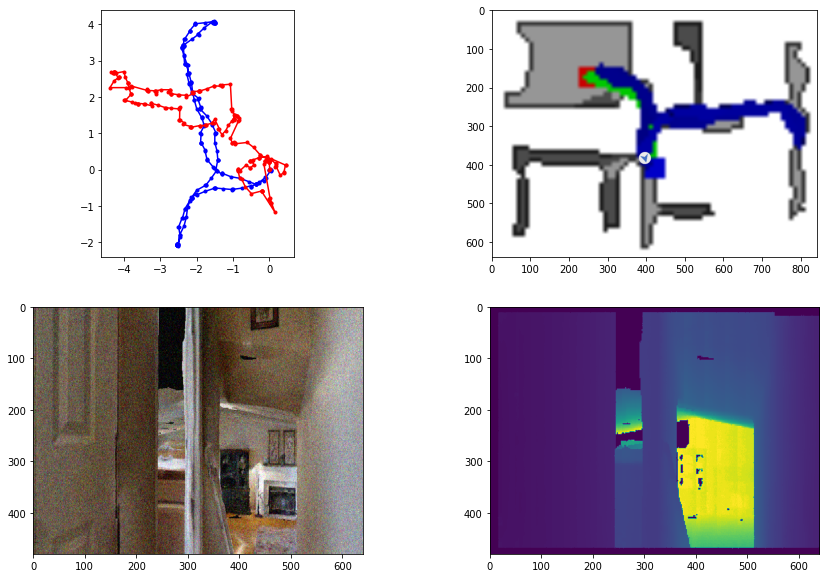

In [17]:
#DFVO + DDPPO 123
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax.set_aspect('equal', adjustable='box')
ax.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
ax.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')

top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
ax2.imshow(top_down_map)
ax3.imshow(obs_rgb)
ax4.imshow(obs_depth)
plt.savefig('./_{}_ddppo.png'.format(n_reset))

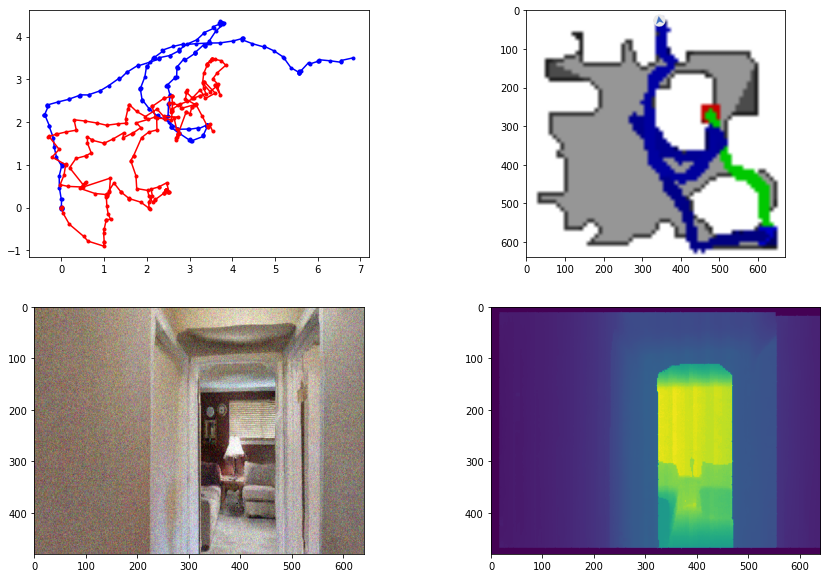

In [46]:
#DFVO + DDPPO 123
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax.set_aspect('equal', adjustable='box')
ax.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
ax.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')

top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
ax2.imshow(top_down_map)
ax3.imshow(obs_rgb)
ax4.imshow(obs_depth)
plt.savefig('./_{}_ddppo.png'.format(n_reset))

In [18]:
!ffmpeg -framerate 10 -pattern_type glob -i '/root/DF-VO/images/*.png' -c:v libx264 -r 20 -pix_fmt yuv420p /root/DF-VO/out.mp4 -y

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

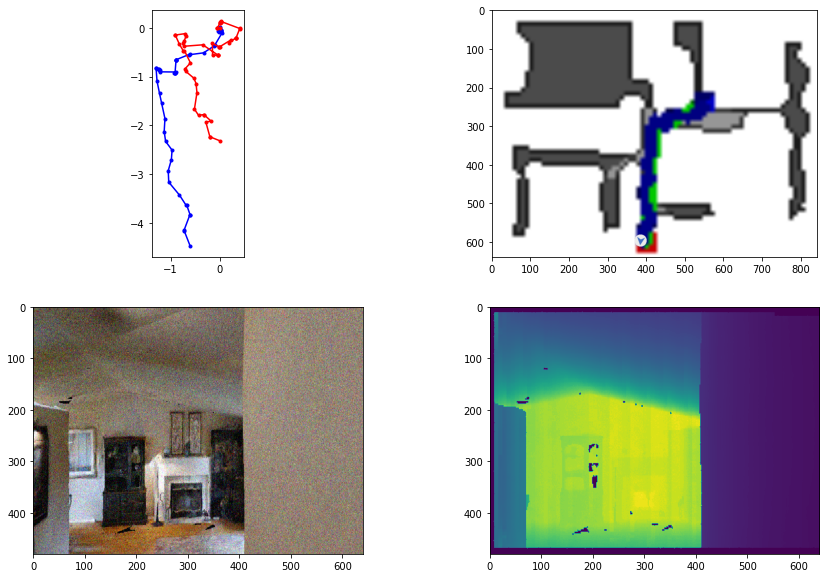

In [32]:
#DFVO + DDPPO 123
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax.set_aspect('equal', adjustable='box')
ax.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
ax.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')

top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
ax2.imshow(top_down_map)
ax3.imshow(obs_rgb)
ax4.imshow(obs_depth)
plt.savefig('./_{}.png'.format(n_reset))

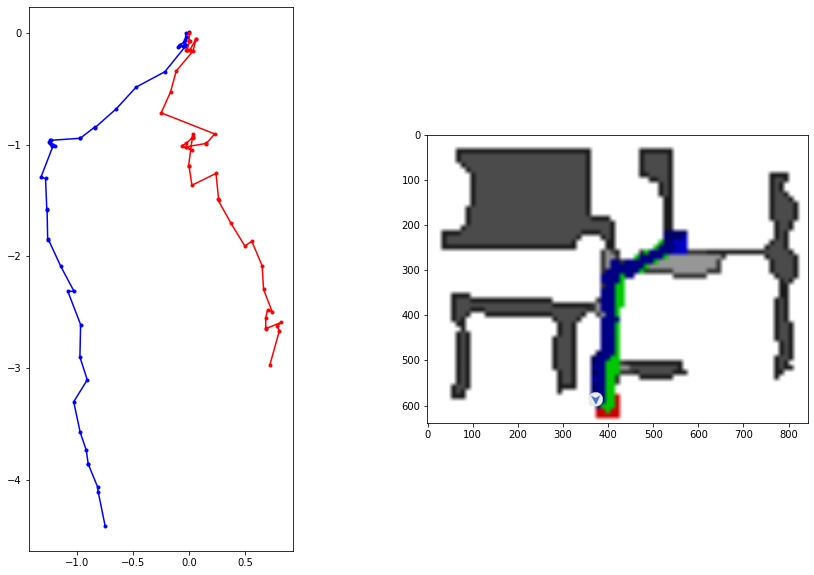

In [21]:
#DFVO + DDPPO 123
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax.set_aspect('equal', adjustable='box')
ax.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
ax.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
ax2.imshow(top_down_map)
ax2.imshow(top_down_map)
ax2.imshow(top_down_map)
plt.savefig('foo.png')

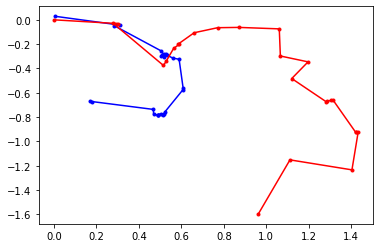

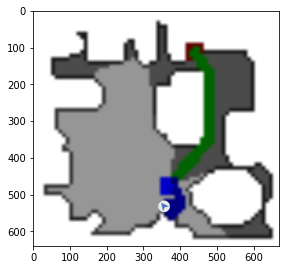

In [27]:
#DFVO + DDPPO 5
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax.imshow(top_down_map)

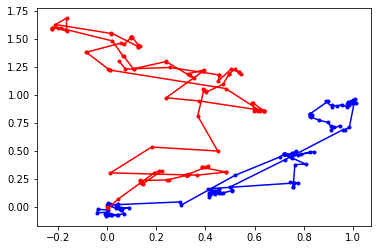

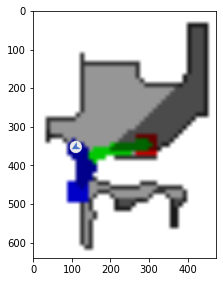

In [21]:
#DFVO + DDPPO 65
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax.imshow(top_down_map)

In [46]:
for i in range(len(pr_1)):
    print([i.round(3) for i in pr_11[i]],'\t',[i.round(3) for i in pr_22[i]],'\t',[i.round(3) for i in pr_33[i]])

[0.004, 0.029] 	 [3.314, 3.146, -122.4] 	 [-0.008, 0.006, -69.43]
[-0.012, 0.021] 	 [3.318, 3.163, -106.18] 	 [0.321, 0.161, -50.731]
[0.177, 0.067] 	 [3.231, 2.99, -103.016] 	 [0.222, 0.306, -48.211]
[0.336, 0.089] 	 [3.145, 2.855, -98.31] 	 [0.19, 0.483, -43.614]
[0.346, 0.093] 	 [3.141, 2.845, -107.655] 	 [0.006, 0.31, -54.777]
[0.313, 0.127] 	 [3.188, 2.847, -98.034] 	 [0.215, 0.41, -43.164]
[0.34, 0.111] 	 [3.158, 2.838, -91.291] 	 [0.38, 0.606, -34.454]
[0.516, 0.228] 	 [3.133, 2.628, -92.862] 	 [0.18, 0.662, -36.882]
[0.772, 0.443] 	 [3.13, 2.294, -91.721] 	 [-0.079, 0.844, -35.865]
[0.749, 0.435] 	 [3.139, 2.316, -102.498] 	 [-0.164, 0.677, -47.597]
[0.764, 0.466] 	 [3.153, 2.285, -113.815] 	 [-0.163, 0.676, -57.028]
[0.748, 0.461] 	 [3.159, 2.3, -100.439] 	 [0.055, 0.804, -42.208]
[0.912, 0.637] 	 [3.186, 2.061, -96.034] 	 [-0.122, 0.891, -38.43]
[0.938, 0.613] 	 [3.151, 2.057, -112.359] 	 [-0.369, 0.662, -57.643]
[0.916, 0.612] 	 [3.164, 2.074, -106.884] 	 [-0.1, 0.815, -48.7

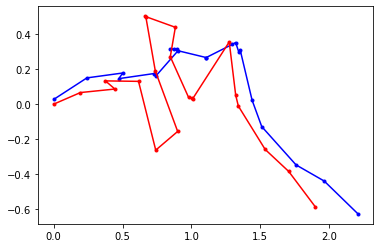

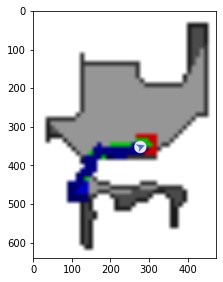

In [21]:
#Action and rgb noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax.imshow(top_down_map)

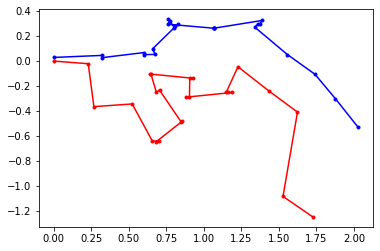

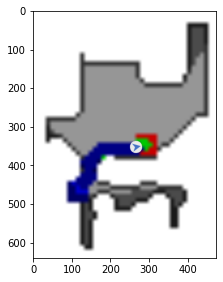

In [32]:
#Action and rgb noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax.imshow(top_down_map)

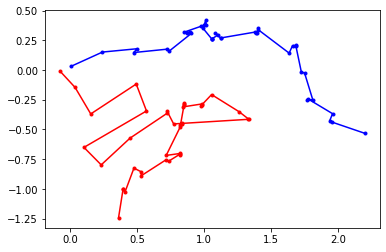

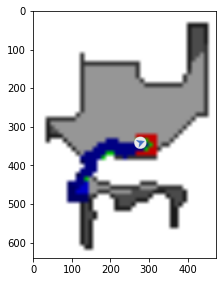

In [57]:
#Action and rgb noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax.imshow(top_down_map)

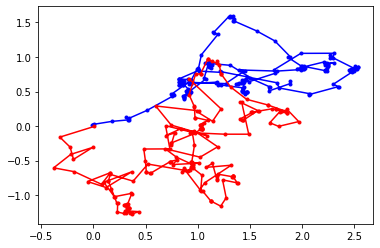

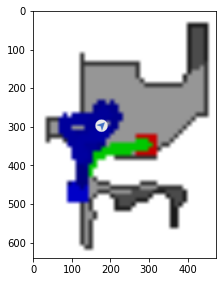

In [47]:
#Action and rgb noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax.imshow(top_down_map)

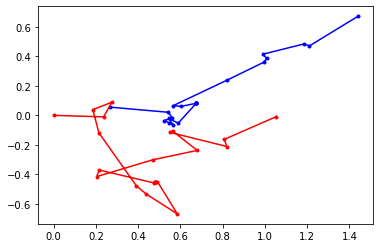

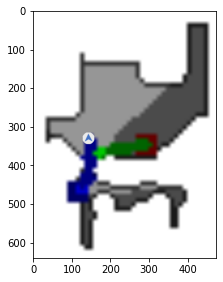

In [126]:
#Action and rgb noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax.imshow(top_down_map)

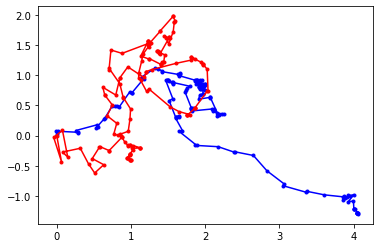

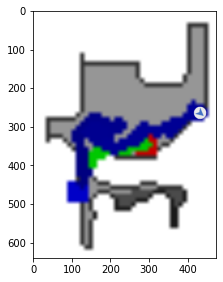

In [120]:
#Action and rgb noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax.imshow(top_down_map)

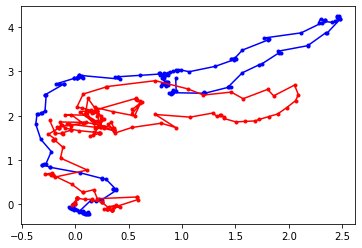

In [107]:
#Action and rgb noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')

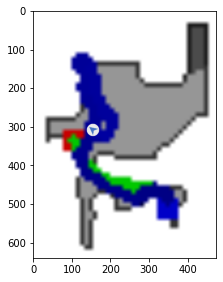

In [113]:
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax.imshow(top_down_map)

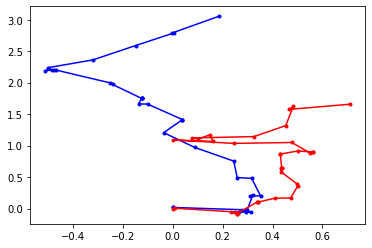

In [12]:
#Action and rgb noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')

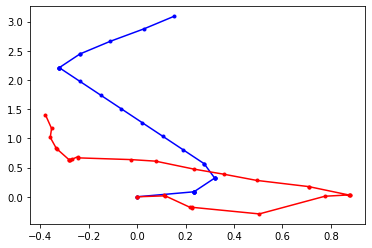

In [13]:
#RGB noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')

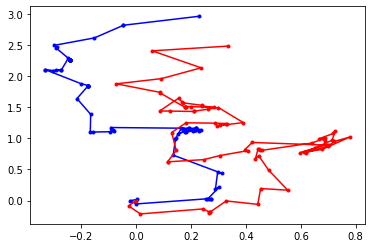

In [37]:
# Action Noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')

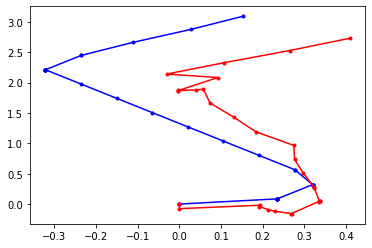

In [23]:
# Without noise
plt.plot(np.array(pr_11)[:,0], np.array(pr_11)[:,1], 'b.-', label='tru')
plt.plot(-np.array(pr_33)[:,0], -np.array(pr_33)[:,1], 'r.-', label='tru')

In [430]:
for i in range(len(pr_1)):
    print([i.round(3) for i in pr_1[i]],'\t',[i.round(3) for i in pr_2[i]],'\t',[i.round(3) for i in pr_3[i]])

[0.0, 0.0, 0.175] 	 [0.0, 0.0, 0.175] 	 [0.0, -0.0, 0.0]
[0.0, 0.0, 0.175] 	 [0.0, 0.0, 0.175] 	 [-0.001, -0.093, -0.191]
[0.0, 0.0, 0.175] 	 [0.0, 0.0, 0.175] 	 [0.001, -0.0, -0.149]
[0.0, 0.0, 0.175] 	 [0.0, 0.0, 0.175] 	 [-0.003, -0.139, -0.199]
[0.0, 0.0, 0.175] 	 [0.0, 0.0, 0.175] 	 [0.008, -0.001, -0.149]
[0.0, 0.0, 0.175] 	 [0.0, 0.0, 0.175] 	 [0.001, -0.0, -0.748]
[0.0, -0.0, 0.175] 	 [0.0, -0.0, 0.175] 	 [0.006, 0.003, 0.148]
[0.0, -0.0, 0.175] 	 [0.0, -0.0, 0.175] 	 [-0.004, -0.001, 0.123]
[0.0, -0.0, 0.175] 	 [0.0, -0.0, 0.175] 	 [0.004, -0.0, -0.123]
[0.0, -0.0, 0.175] 	 [0.0, -0.0, 0.175] 	 [0.005, -0.0, -0.148]
[0.0, -0.0, 0.175] 	 [0.0, -0.0, 0.175] 	 [0.006, -0.001, -0.149]
[0.0, -0.0, 0.175] 	 [0.0, -0.0, 0.175] 	 [-0.006, -0.144, -0.214]
[0.0, -0.0, 0.175] 	 [0.0, -0.0, 0.175] 	 [0.01, -0.001, -0.149]
[0.25, 0.0, 0.0] 	 [0.25, 0.0, 0.0] 	 [-0.244, 0.004, 0.001]
[0.25, 0.0, 0.0] 	 [0.25, 0.0, 0.0] 	 [-0.229, 0.005, 0.003]
[0.25, 0.0, 0.0] 	 [0.25, 0.0, 0.0] 	 [-0.358, 

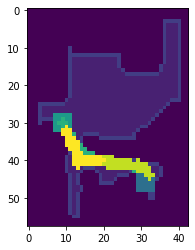

In [13]:
plt.imshow(info['top_down_map']['map'])

In [11]:
vo.cfg.result_dir = './results/52'
os.mkdir(vo.cfg.result_dir)
vo.cfg.seq = '52'
traj_txt = "{}/{}.txt".format(vo.cfg.result_dir, vo.cfg.seq)
timestamps = sorted(list(vo.rgb_d_pose_pair.keys()))
global_poses_arr = convert_SE3_to_arr(vo.global_poses, timestamps)
save_traj(traj_txt, global_poses_arr, format="tum")

Trajectory saved.
